# Imports

In [1]:
import random
import time
import enum
import math
from collections import namedtuple
from multiprocessing.pool import Pool
from typing import Tuple, NamedTuple, List
from tqdm import tqdm

import numpy as np
import pandas as pd
import pylab as plt
import networkx as nx
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
import plotnine as p9
import scipy
import sys

sys.path.insert(0, "./lib")

from lib.networkgen import Network, NetworkType
from lib.model import ModelWrapper
from lib.modelgen import Model, SIRModel, SEIZModel, SEIZplusModel, SEIZMModel, MoneyAgent
ModelType = Model.ModelType

# Initial Parameters: WE USE NETWORK PARAMETERS 5

In [2]:
 # TODO: Simulation parameters

params = {
    ModelType.SIR: { # TODO
        'model': SIRModel.Params(
            initial_infected=0.01,
            initial_disagree=0.01,
            p_opinion_change=0.03
        ),
        'agent': None,
        'state_labels': [("Unsure", 'cornflowerblue'), ("Disagree","green"), ("Believe",'red')]
    },
    ModelType.SEIZ: { # TODO
        'model': SEIZModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=0.03,
            prob_S_with_Z=0.03,
            prob_E_to_I=0.01
        ),
        'agent': None,
        'state_labels': [("Susceptible", 'cornflowerblue'), ("Exposed", "orange"), ("Skeptic","green"), ("Infected",'red')]
    },
    ModelType.SEIZplus: {
        'model': SEIZplusModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=0.03,
            prob_S_with_Z=0.03,
            neighbor_threshold=0.7
        ),
        'agent': None,
        'state_labels': [("Susceptible", 'cornflowerblue'), ("Exposed", "orange"), ("Skeptic","green"), ("Infected",'red')]
    },
    ModelType.SEIZM: { # TODO
        'model': SEIZMModel.Params(
            initial_infected = 0.01,
            initial_skeptics = 0.01,
            prob_S_with_I = 0.03,
            prob_S_with_Z = 0.03,
            certainty_threshold = 0.3,
            influence_threshold = 0.3,
            money_theshold = 0.3,
            influence_increase = 0.1,
            certainty_increase = 0.1,
            neighbor_threshold = 0.8
        ),
        'agent': MoneyAgent.Params(
            0.5,    # certainty
            0.5,    # influence
            0,      # money
            0.5     # sentiment
        ),
        'state_labels': [("Susceptible", 'cornflowerblue'), ("Exposed", "orange"), ("Skeptic","green"), ("Infected",'red')]
    }
}

network_params = {
    # Parameters are chosen such that all networks have similar density
    NetworkType.CAVEMAN: (3,40),  # (l, k)
    NetworkType.WINDMILL: (3,41),  # (n, k)
    NetworkType.SMALLWORLD: (120, 40,0.05),
    NetworkType.BARABASI_ALBERT: (120,21,84,0.4)  # (n, m1, m2, p)
}

# Helper functions

In [3]:
# TODO: Model Generation

def create_model(dynamics, network):
    # dynamics = ModelType.SEIZplus
    # network = NetworkType.CAVEMAN

    model = ModelWrapper(
        model_type=dynamics,
        model_params=params[dynamics]['model'],
        agent_params=params[dynamics]['agent'],
        network_type=network,
        network_params=network_params[network]
    )

    return model
# convenience function to collect plotable data
def sum_agents(model, state_labels):
    agent_data = model.data_collector().get_agent_vars_dataframe()

    # sum up different opinions each (time) step
    agents_summed = pd.pivot_table(agent_data, index = 'Step', columns = 'State', aggfunc = np.size, fill_value = 0)
   
    #check whether exposed state never occured and add if not
    if not 1 in agents_summed.columns:
        agents_summed[1] = 0
    
    #reorder state columns
    agents_summed = agents_summed.reindex(sorted(agents_summed.columns), axis = 1)
        
    # relabel
    labels = [l[0] for l in state_labels]
       
    agents_summed.columns = labels
    return agents_summed


# run multiple replicates of the model:
def run_replicates(new_model, state_labels, n_replicates, n_steps):

    for i in tqdm(range(n_replicates), desc="Run"):

        #(re-)initiate model
        model = new_model()

        #run model
        model.run(n_steps)

        #data collection
        if i == 0:
            replicates = sum_agents(model, state_labels)
        else:
            replicates = pd.concat([replicates, sum_agents(model, state_labels)])

    #calculate means and standard error of the mean
    replicates = pd.pivot_table(replicates, index = ["Step"], aggfunc = [np.mean, scipy.stats.sem])

    return replicates

# plot trajectories with errors:
def plot_trajectories(data, colors_ggplot):
    # data wrangling for ggplot
    data = data.stack(level=1).reset_index(1).rename(columns={"level_1": "Population"}).sort_values("Population")
    data.reset_index(inplace=True)
    data = data.rename(columns = {'index':'Step'})

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'Step', y = "mean", fill = "Population", group = "Population", color = "Population"))
    + p9.geom_line()
    + p9.geom_ribbon(p9.aes(x = 'Step', ymin = data["mean"] - data["sem"], ymax = data["mean"] + data["sem"]), outline_type = "none", alpha = 0.25, show_legend = False)
    + p9.ylab("Population size")
    + p9.xlab("Step")
    + p9.scale_color_manual(values = colors_ggplot)
    + p9.scale_fill_manual(values = colors_ggplot)
    + p9.coord_cartesian(ylim = {0, max(data['mean'])}, xlim = {0, max(data["Step"])})
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
def run_trajectories(dynamics, network, n_steps = 200, n_replicates = 10):
    df = run_replicates(
        lambda: create_model(dynamics, network),
        state_labels=params[dynamics]['state_labels'],
        n_replicates = n_replicates,
        n_steps = n_steps)

    plot_trajectories(df, {label: color for label, color in params[dynamics]['state_labels']})

### SEIZ P(SE) VS P(SI), P(EI)=0.01

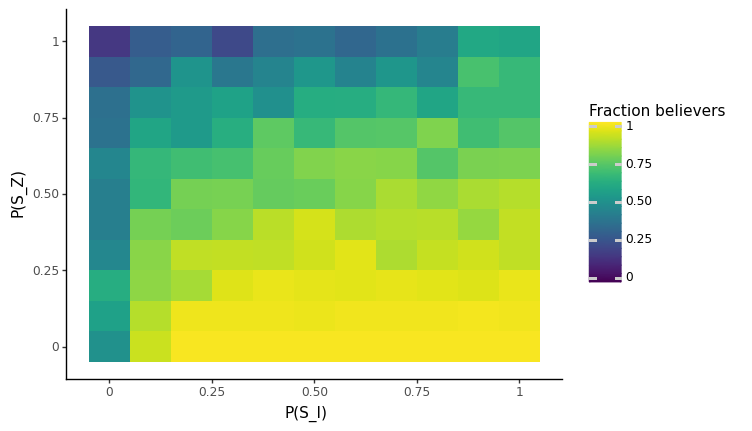

In [4]:
# TODO: Phase Diagram

# this throws an error stochastically because something goes wrong with the labels, which I dont get.
# how can it be  that it works most of the time and then not? and how can it be the same error as with the windmill network?

dynamics, network = ModelType.SEIZ, NetworkType.CAVEMAN

def phase_diagram(n_steps = 200, n_replicates = 10, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 1, para_1_max = 1, para_1_by = 0.1, para_2_by = 0.1):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZModel.Params(
            initial_infected = 0.01,
            initial_skeptics = 0.01,
            prob_S_with_I = i,
            prob_S_with_Z = k,
            prob_E_to_I = 0.01
            )   
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)

def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
#phase plot test

#run model data - this takes aSMALLWORLD!
test = phase_diagram() 
#plot it:
test_phase = plot_phase_diagram(test, str("P(S_Z)"), str("P(S_I)"))


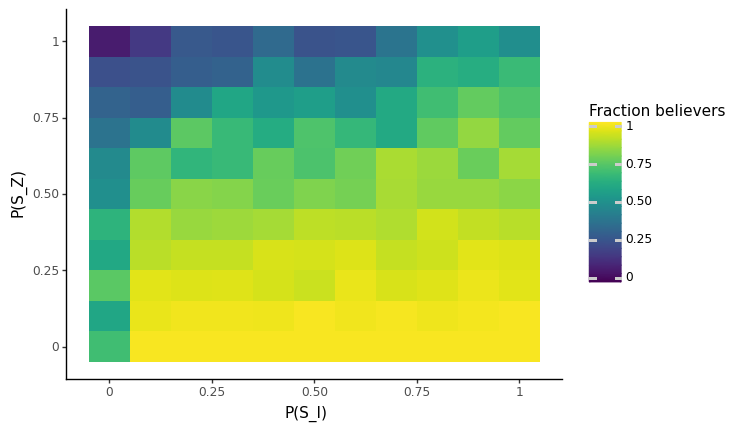

In [5]:
# TODO: Phase Diagram

# this throws an error stochastically because something goes wrong with the labels, which I dont get.
# how can it be  that it works most of the time and then not? and how can it be the same error as with the windmill network?

dynamics, network = ModelType.SEIZ, NetworkType.WINDMILL

def phase_diagram(n_steps = 200, n_replicates = 10, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 1, para_1_max = 1, para_1_by = 0.1, para_2_by = 0.1):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZModel.Params(
            initial_infected = 0.01,
            initial_skeptics = 0.01,
            prob_S_with_I = i,
            prob_S_with_Z = k,
            prob_E_to_I = 0.01
            )   
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)

def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
#phase plot test

#run model data - this takes aSMALLWORLD!
test = phase_diagram() 
#plot it:
test_phase = plot_phase_diagram(test, str("P(S_Z)"), str("P(S_I)"))


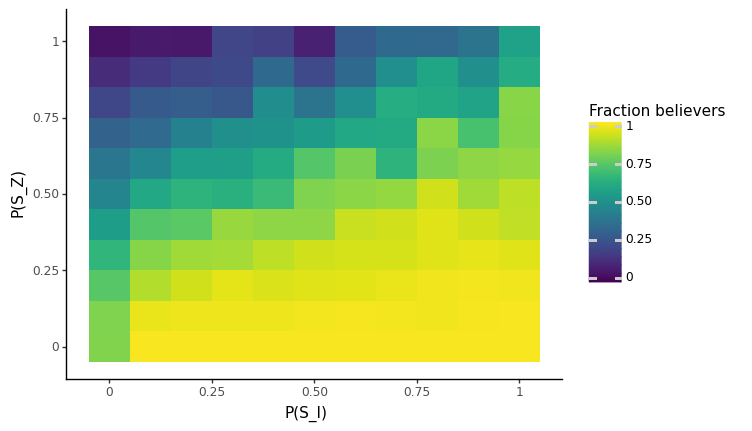

In [6]:
# TODO: Phase Diagram

# this throws an error stochastically because something goes wrong with the labels, which I dont get.
# how can it be  that it works most of the time and then not? and how can it be the same error as with the windmill network?

dynamics, network = ModelType.SEIZ, NetworkType.SMALLWORLD

def phase_diagram(n_steps = 200, n_replicates = 10, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 1, para_1_max = 1, para_1_by = 0.1, para_2_by = 0.1):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZModel.Params(
            initial_infected = 0.01,
            initial_skeptics = 0.01,
            prob_S_with_I = i,
            prob_S_with_Z = k,
            prob_E_to_I = 0.01
            )   
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)

def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
#phase plot test

#run model data - this takes aSMALLWORLD!
test = phase_diagram() 
#plot it:
test_phase = plot_phase_diagram(test, str("P(S_Z)"), str("P(S_I)"))


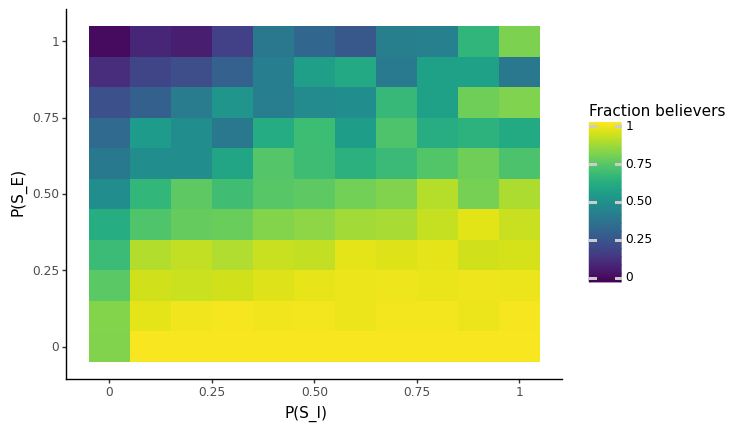

In [7]:
# TODO: Phase Diagram

# this throws an error stochastically because something goes wrong with the labels, which I dont get.
# how can it be  that it works most of the time and then not? and how can it be the same error as with the windmill network?

dynamics, network = ModelType.SEIZ, NetworkType.BARABASI_ALBERT

def phase_diagram(n_steps = 200, n_replicates = 10, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 1, para_1_max = 1, para_1_by = 0.1, para_2_by = 0.1):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZModel.Params(
            initial_infected = 0.01,
            initial_skeptics = 0.01,
            prob_S_with_I = i,
            prob_S_with_Z = k,
            prob_E_to_I = 0.01
            )   
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)

def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
#phase plot test

#run model data - this takes aSMALLWORLD!
test = phase_diagram() 
#plot it:
test_phase = plot_phase_diagram(test, str("P(S_E)"), str("P(S_I)"))


### Not P(S_I)(S_Z), NOT VERY INTERSTING

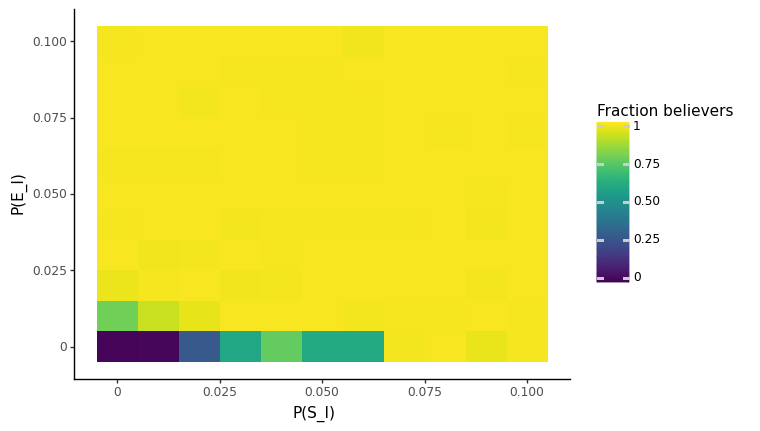

In [8]:
# TODO: Phase Diagram

# this throws an error stochastically because something goes wrong with the labels, which I dont get.
# how can it be  that it works most of the time and then not? and how can it be the same error as with the windmill network?

dynamics, network = ModelType.SEIZ, NetworkType.BARABASI_ALBERT

def phase_diagram(n_steps = 200, n_replicates = 5, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 0.1, para_1_max = 0.1, para_1_by = 0.01, para_2_by = 0.01):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZModel.Params(
            initial_infected = 0.01,
            initial_skeptics = 0.01,
            prob_S_with_I = i,
            prob_S_with_Z = 0.03,
            prob_E_to_I = k
            )   
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)

def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
#phase plot test

#run model data - this takes aSMALLWORLD!
test = phase_diagram() 
#plot it:
test_phase = plot_phase_diagram(test, str("P(E_I)"), str("P(S_I)"))

### Interesting to compare, P(EI) VS P(SZ)

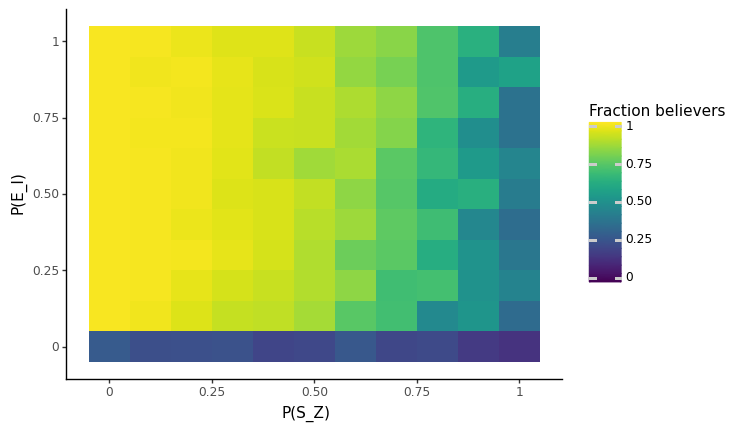

In [9]:
# TODO: Phase Diagram

# this throws an error stochastically because something goes wrong with the labels, which I dont get.
# how can it be  that it works most of the time and then not? and how can it be the same error as with the windmill network?

dynamics, network = ModelType.SEIZ, NetworkType.CAVEMAN

def phase_diagram(n_steps = 200, n_replicates = 10, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 1, para_1_max = 1, para_1_by = 0.1, para_2_by = 0.1):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZModel.Params(
            initial_infected = 0.01,
            initial_skeptics = 0.01,
            prob_S_with_I = 0.03,
            prob_S_with_Z = i,
            prob_E_to_I = k
            )   
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)

def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
#phase plot test

#run model data - this takes aSMALLWORLD!
test = phase_diagram() 
#plot it:
test_phase = plot_phase_diagram(test, str("P(E_I)"), str("P(S_Z)"))

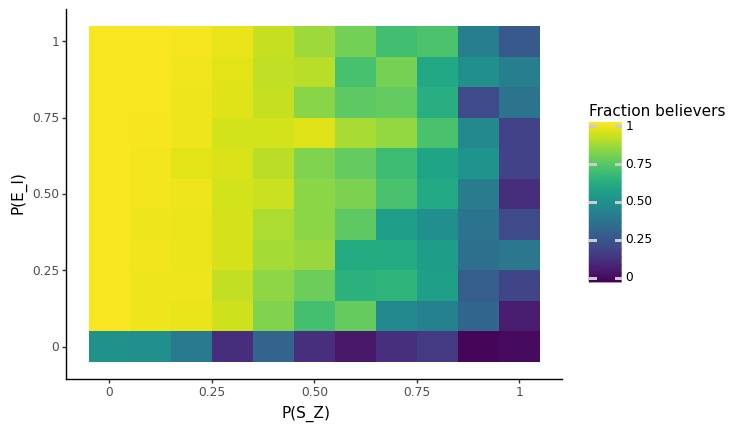

In [10]:
# TODO: Phase Diagram

# this throws an error stochastically because something goes wrong with the labels, which I dont get.
# how can it be  that it works most of the time and then not? and how can it be the same error as with the windmill network?

dynamics, network = ModelType.SEIZ, NetworkType.BARABASI_ALBERT

def phase_diagram(n_steps = 200, n_replicates = 10, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 1, para_1_max = 1, para_1_by = 0.1, para_2_by = 0.1):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZModel.Params(
            initial_infected = 0.01,
            initial_skeptics = 0.01,
            prob_S_with_I = 0.03,
            prob_S_with_Z = i,
            prob_E_to_I = k
            )   
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)

def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
#phase plot test

#run model data - this takes aSMALLWORLD!
test = phase_diagram() 
#plot it:
test_phase = plot_phase_diagram(test, str("P(E_I)"), str("P(S_Z)"))

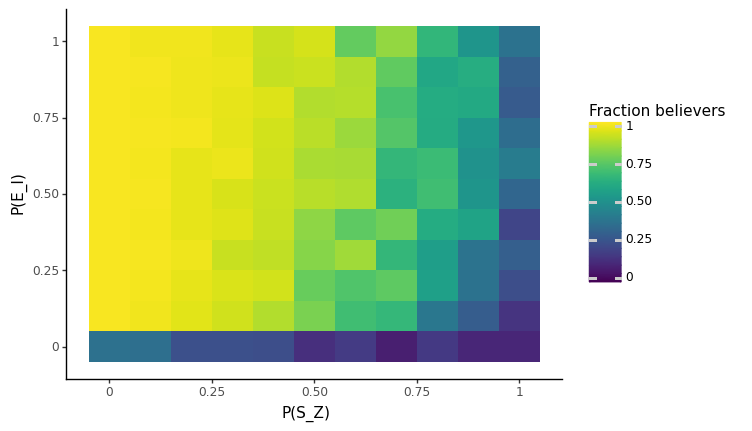

In [11]:
# TODO: Phase Diagram

# this throws an error stochastically because something goes wrong with the labels, which I dont get.
# how can it be  that it works most of the time and then not? and how can it be the same error as with the windmill network?

dynamics, network = ModelType.SEIZ, NetworkType.WINDMILL

def phase_diagram(n_steps = 200, n_replicates = 10, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 1, para_1_max = 1, para_1_by = 0.1, para_2_by = 0.1):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZModel.Params(
            initial_infected = 0.01,
            initial_skeptics = 0.01,
            prob_S_with_I = 0.03,
            prob_S_with_Z = i,
            prob_E_to_I = k
            )   
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)

def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
#phase plot test

#run model data - this takes aSMALLWORLD!
test = phase_diagram() 
#plot it:
test_phase = plot_phase_diagram(test, str("P(E_I)"), str("P(S_Z)"))

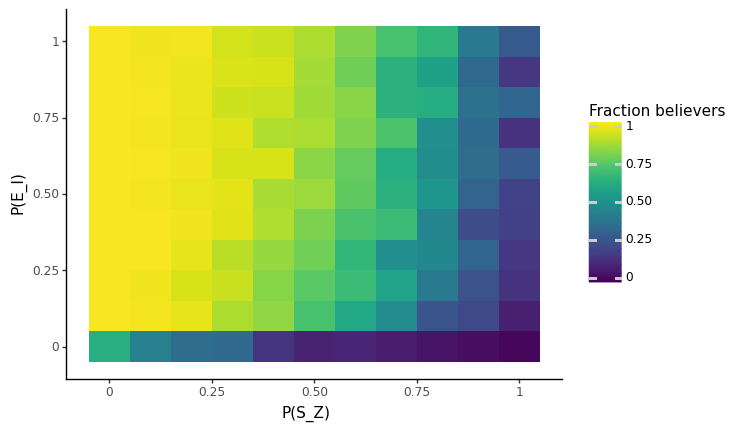

In [12]:
# TODO: Phase Diagram

# this throws an error stochastically because something goes wrong with the labels, which I dont get.
# how can it be  that it works most of the time and then not? and how can it be the same error as with the windmill network?

dynamics, network = ModelType.SEIZ, NetworkType.SMALLWORLD

def phase_diagram(n_steps = 200, n_replicates = 10, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 1, para_1_max = 1, para_1_by = 0.1, para_2_by = 0.1):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZModel.Params(
            initial_infected = 0.01,
            initial_skeptics = 0.01,
            prob_S_with_I = 0.03,
            prob_S_with_Z = i,
            prob_E_to_I = k
            )   
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)

def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
#phase plot test

#run model data - this takes aSMALLWORLD!
test = phase_diagram() 
#plot it:
test_phase = plot_phase_diagram(test, str("P(E_I)"), str("P(S_Z)"))

### SEIZ+ P(SE) VS P(SI), Neighbor_threshol=0.7

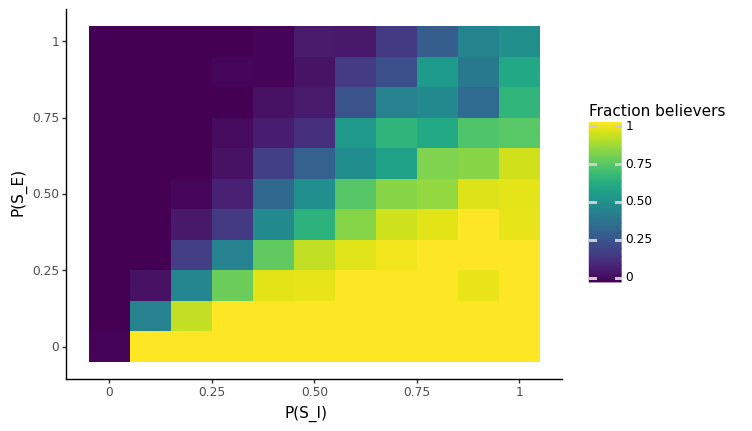

In [13]:
# TODO: Phase Diagram

# this throws an error stochastically because something goes wrong with the labels, which I dont get.
# how can it be  that it works most of the time and then not? and how can it be the same error as with the windmill network?

dynamics, network = ModelType.SEIZplus, NetworkType.CAVEMAN

def phase_diagram(n_steps = 200, n_replicates = 10, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 1, para_1_max = 1, para_1_by = 0.1, para_2_by = 0.1):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZplusModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=i,
            prob_S_with_Z=k,
            neighbor_threshold=0.7
        )
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)

def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
#phase plot test

#run model data - this takes aSMALLWORLD!
test = phase_diagram() 
#plot it:
test_phase = plot_phase_diagram(test, str("P(S_E)"), str("P(S_I)"))


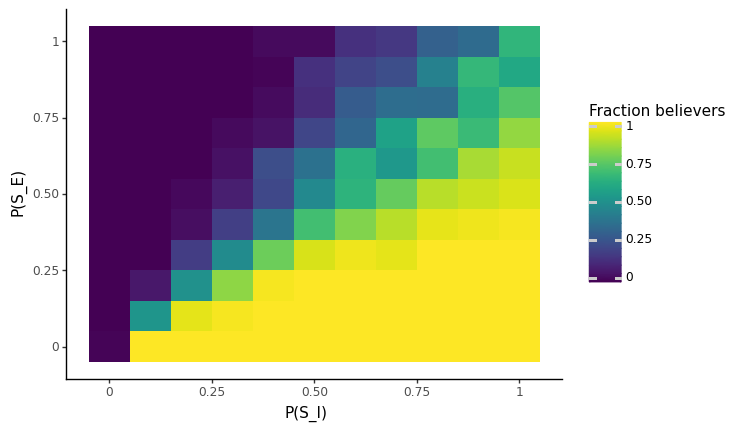

In [14]:
# TODO: Phase Diagram

# this throws an error stochastically because something goes wrong with the labels, which I dont get.
# how can it be  that it works most of the time and then not? and how can it be the same error as with the windmill network?

dynamics, network = ModelType.SEIZplus, NetworkType.WINDMILL

def phase_diagram(n_steps = 200, n_replicates = 10, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 1, para_1_max = 1, para_1_by = 0.1, para_2_by = 0.1):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZplusModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=i,
            prob_S_with_Z=k,
            neighbor_threshold=0.7
        )
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)

def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
#phase plot test

#run model data - this takes aSMALLWORLD!
test = phase_diagram() 
#plot it:
test_phase = plot_phase_diagram(test, str("P(S_E)"), str("P(S_I)"))


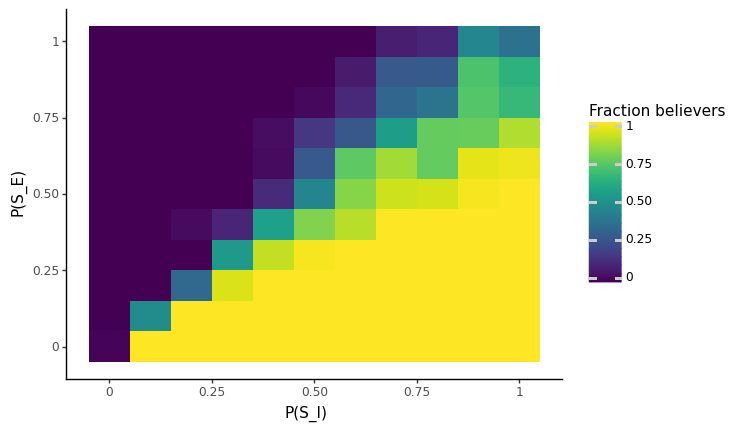

In [15]:
# TODO: Phase Diagram

# this throws an error stochastically because something goes wrong with the labels, which I dont get.
# how can it be  that it works most of the time and then not? and how can it be the same error as with the windmill network?

dynamics, network = ModelType.SEIZplus, NetworkType.SMALLWORLD

def phase_diagram(n_steps = 200, n_replicates = 10, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 1, para_1_max = 1, para_1_by = 0.1, para_2_by = 0.1):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZplusModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=i,
            prob_S_with_Z=k,
            neighbor_threshold=0.7
        )
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)

def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
#phase plot test

#run model data - this takes aSMALLWORLD!
test = phase_diagram() 
#plot it:
test_phase = plot_phase_diagram(test, str("P(S_E)"), str("P(S_I)"))

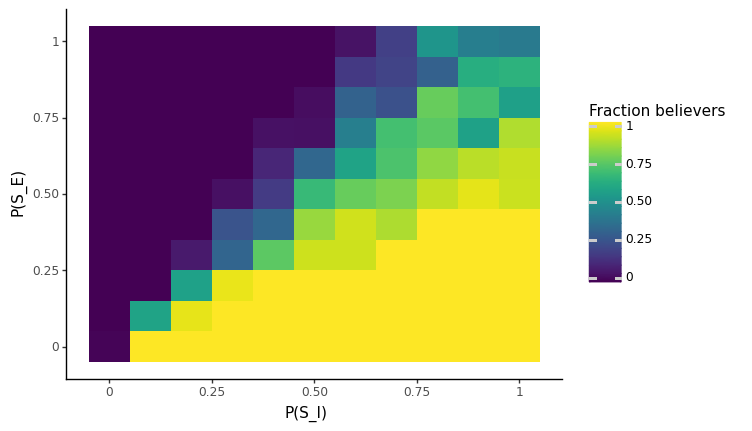

In [16]:
# TODO: Phase Diagram

# this throws an error stochastically because something goes wrong with the labels, which I dont get.
# how can it be  that it works most of the time and then not? and how can it be the same error as with the windmill network?

dynamics, network = ModelType.SEIZplus, NetworkType.BARABASI_ALBERT

def phase_diagram(n_steps = 200, n_replicates = 10, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 1, para_1_max = 1, para_1_by = 0.1, para_2_by = 0.1):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZplusModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=i,
            prob_S_with_Z=k,
            neighbor_threshold=0.7
        )
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)

def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
#phase plot test

#run model data - this takes aSMALLWORLD!
test = phase_diagram() 
#plot it:
test_phase = plot_phase_diagram(test, str("P(S_E)"), str("P(S_I)"))

### P(SZ) VS NEIGHBOUR

In [17]:
# TODO: Phase Diagram

# this throws an error stochastically because something goes wrong with the labels, which I dont get.
# how can it be  that it works most of the time and then not? and how can it be the same error as with the windmill network?

dynamics, network = ModelType.SEIZplus, NetworkType.SMALLWORLD

def phase_diagram(n_steps = 200, n_replicates = 10, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 0.2, para_1_max = 1, para_1_by = 0.1, para_2_by = 0.01):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZplusModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=0.03,
            prob_S_with_Z=i,
            neighbor_threshold=k
        )
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)

def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
#phase plot test

#run model data - this takes aSMALLWORLD!
test = phase_diagram() 
#plot it:
test_phase = plot_phase_diagram(test, str("Neighbor threshold"), str("P(S_Z)"))

KeyboardInterrupt: 

In [ ]:
# TODO: Phase Diagram

# this throws an error stochastically because something goes wrong with the labels, which I dont get.
# how can it be  that it works most of the time and then not? and how can it be the same error as with the windmill network?

dynamics, network = ModelType.SEIZplus, NetworkType.WINDMILL

def phase_diagram(n_steps = 200, n_replicates = 10, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 0.2, para_1_max = 1, para_1_by = 0.1, para_2_by = 0.01):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZplusModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=0.03,
            prob_S_with_Z=i,
            neighbor_threshold=k
        )
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)

def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
#phase plot test

#run model data - this takes aSMALLWORLD!
test = phase_diagram() 
#plot it:
test_phase = plot_phase_diagram(test, str("Neighbor threshold"), str("P(S_Z)"))

In [ ]:
# TODO: Phase Diagram

# this throws an error stochastically because something goes wrong with the labels, which I dont get.
# how can it be  that it works most of the time and then not? and how can it be the same error as with the windmill network?

dynamics, network = ModelType.SEIZplus, NetworkType.CAVEMAN

def phase_diagram(n_steps = 200, n_replicates = 10, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 0.2, para_1_max = 1, para_1_by = 0.1, para_2_by = 0.01):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZplusModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=0.03,
            prob_S_with_Z=i,
            neighbor_threshold=k
        )
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)

def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
#phase plot test

#run model data - this takes aSMALLWORLD!
test = phase_diagram() 
#plot it:
test_phase = plot_phase_diagram(test, str("Neighbor threshold"), str("P(S_Z)"))

In [ ]:
# TODO: Phase Diagram

# this throws an error stochastically because something goes wrong with the labels, which I dont get.
# how can it be  that it works most of the time and then not? and how can it be the same error as with the windmill network?

dynamics, network = ModelType.SEIZplus, NetworkType.BARABASI_ALBERT

def phase_diagram(n_steps = 200, n_replicates = 10, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 0.2, para_1_max = 1, para_1_by = 0.1, para_2_by = 0.01):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZplusModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=0.03,
            prob_S_with_Z=i,
            neighbor_threshold=k
        )
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)

def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
#phase plot test

#run model data - this takes aSMALLWORLD!
test = phase_diagram() 
#plot it:
test_phase = plot_phase_diagram(test, str("Neighbor threshold"), str("P(S_Z)"))

### P(SI) VS NEIGHBOR THRESHOLD

In [ ]:
# TODO: Phase Diagram

# this throws an error stochastically because something goes wrong with the labels, which I dont get.
# how can it be  that it works most of the time and then not? and how can it be the same error as with the windmill network?

dynamics, network = ModelType.SEIZplus, NetworkType.CAVEMAN

def phase_diagram(n_steps = 200, n_replicates = 10, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 0.2, para_1_max = 1, para_1_by = 0.1, para_2_by = 0.01):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZplusModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=i,
            prob_S_with_Z=0.03,
            neighbor_threshold=k
        )
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)

def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
#phase plot test

#run model data - this takes aSMALLWORLD!
test = phase_diagram() 
#plot it:
test_phase = plot_phase_diagram(test, str("Neighbor threshold"), str("P(S_I)"))

In [ ]:
# TODO: Phase Diagram

# this throws an error stochastically because something goes wrong with the labels, which I dont get.
# how can it be  that it works most of the time and then not? and how can it be the same error as with the windmill network?

dynamics, network = ModelType.SEIZplus, NetworkType.WINDMILL

def phase_diagram(n_steps = 200, n_replicates = 10, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 0.2, para_1_max = 1, para_1_by = 0.1, para_2_by = 0.01):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZplusModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=i,
            prob_S_with_Z=0.03,
            neighbor_threshold=k
        )
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)

def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
#phase plot test

#run model data - this takes aSMALLWORLD!
test = phase_diagram() 
#plot it:
test_phase = plot_phase_diagram(test, str("Neighbor threshold"), str("P(S_I)"))

In [ ]:
# TODO: Phase Diagram

# this throws an error stochastically because something goes wrong with the labels, which I dont get.
# how can it be  that it works most of the time and then not? and how can it be the same error as with the windmill network?

dynamics, network = ModelType.SEIZplus, NetworkType.SMALLWORLD

def phase_diagram(n_steps = 200, n_replicates = 10, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 0.2, para_1_max = 1, para_1_by = 0.1, para_2_by = 0.01):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZplusModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=i,
            prob_S_with_Z=0.03,
            neighbor_threshold=k
        )
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)

def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
#phase plot test

#run model data - this takes aSMALLWORLD!
test = phase_diagram() 
#plot it:
test_phase = plot_phase_diagram(test, str("Neighbor threshold"), str("P(S_I)"))

In [ ]:
# TODO: Phase Diagram

# this throws an error stochastically because something goes wrong with the labels, which I dont get.
# how can it be  that it works most of the time and then not? and how can it be the same error as with the windmill network?

dynamics, network = ModelType.SEIZplus, NetworkType.BARABASI_ALBERT

def phase_diagram(n_steps = 200, n_replicates = 10, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 0.2, para_1_max = 1, para_1_by = 0.1, para_2_by = 0.01):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZplusModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=i,
            prob_S_with_Z=0.03,
            neighbor_threshold=k
        )
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)

def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot
#phase plot test

#run model data - this takes aSMALLWORLD!
test = phase_diagram() 
#plot it:
test_phase = plot_phase_diagram(test, str("Neighbor threshold"), str("P(S_I)"))